In [2]:
import numpy as np
import matplotlib.pyplot as plt
import PIL

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator
from qiskit.providers.ibmq import least_busy

from PIL import Image

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

ibmqfactory.load_account:WARNING:2022-09-29 06:43:08,152: Credentials are already in use. The existing account in the session will be replaced.


In [3]:
# Loading our image in the Quantum State
test_image = Image.open('test_4x4_image.tif')
np_test_image = np.array(test_image)

# We need to do this so that we take only a single channel of the color data in the .tif image
test_image_final = []
for row in np_test_image:
    for pixel in row:
        test_image_final.append( pixel[0] / 256)

np_test_image = np.array(test_image_final)

np_test_image = np_test_image.reshape((4,4))
print(np_test_image)


[[0.8125     0.84765625 0.86328125 0.8515625 ]
 [0.88671875 0.89453125 0.22265625 0.8984375 ]
 [0.2890625  0.890625   0.49609375 0.8984375 ]
 [0.43359375 0.89453125 0.38671875 0.4375    ]]


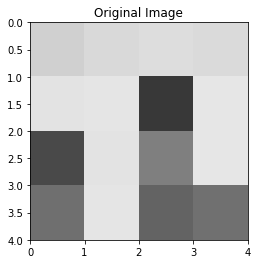

In [4]:
# Function to plot our image
def plot_image4x4(img, title: str):
    plt.title(title)
    plt.imshow(img, extent=[0, 4, 4, 0], vmin=0, vmax=1, cmap='gray')
    plt.show()
    
plot_image4x4(np_test_image, "Original Image")   

[[0.2778443  0.2898664  0.29520956 0.29120219]
 [0.3032243  0.30589588 0.07614002 0.30723167]
 [0.09884845 0.30456009 0.16964532 0.30723167]
 [0.14827268 0.30589588 0.1322432  0.14960847]]


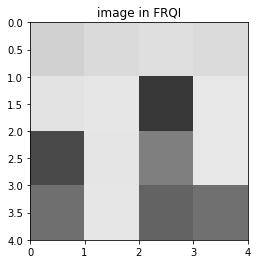

In [5]:
# We need to normalize our input image before passing it as the input quantum state.
def normalize(array):
    rms = np.sqrt(np.sum(np.sum(array**2)))
    ret_array = []
    for i in array:
        ret_array.append( (i * (1/rms)) )
    
    npret_array = np.array(ret_array)
    return npret_array

# The normalized image is too dark, so we brighten it with this method
def plot_image4x4_brightened(img, title: str):
    plt.title(title)
    plt.imshow(img, extent=[0, 4, 4, 0], vmin=0, vmax=0.34, cmap='gray')
    plt.show()
    

np_test_image_normalized = normalize(np_test_image)
print(np_test_image_normalized)

plot_image4x4_brightened(np_test_image_normalized, 'image in FRQI')

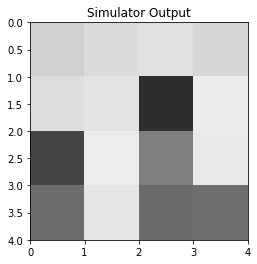

In [6]:
# We're just copying the image arrays from Working_with_FRQI.ipynb:
simulator_output = [0.2770379, 0.29197603, 0.29874738, 0.28504386,
 0.29453353, 0.30248967, 0.06123724, 0.31104662,
 0.09082951, 0.31424513, 0.16881943, 0.31064449,
 0.14491377, 0.30618622, 0.14230249, 0.14747881]
np_simulator_output = np.array(simulator_output).reshape((4,4))
plot_image4x4_brightened(np_simulator_output, 'Simulator Output')

In [31]:
# We need to modify the RMSE error to take into account the decrease brightness when normalizing 
def un_normalize(true_image, true_image_normalized, image, n):
    normalization_factor = 0.0
    for x in range(n):
        for y in range(n):
            normalization_factor += (true_image_normalized[y][x] / true_image[y][x])
    
    #The average normalization factor, to account for floating point errors.
    normalization_factor /= (n**2)
    
    image = image / normalization_factor
    return image

def rmse_image_error(true_image, error_image, n):
    rms_error = 0.0
    for y in range(n):
        for x in range(n):
            rms_error += ((true_image[y][x] - error_image[y][x]) ** 2)
            
    rms_error = np.sqrt(rms_error)
    return (rms_error / (n**2))

In [25]:
np_image_to_print = un_normalize(np_test_image, np_test_image_normalized, np_simulator_output, 4)
print(np_image_to_print)

[[0.81014186 0.85382543 0.87362688 0.83355368]
 [0.86130432 0.88457046 0.17907604 0.90959355]
 [0.26561271 0.91894695 0.49367861 0.9084176 ]
 [0.4237713  0.89538028 0.41613513 0.43127224]]


In [23]:
print(image_error(np_test_image_normalized, np_simulator_output, 4))

0.025823336717180137


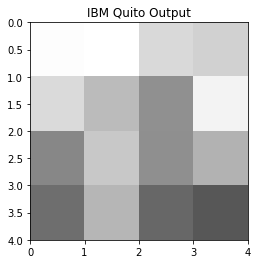

0.20965361752722306


In [8]:
ibm_quito_output = [0.33689761, 0.3588175, 0.28939592, 0.27883687,
 0.29068884, 0.24899799, 0.19235384, 0.32287769,
 0.17958285, 0.26598872, 0.19039433, 0.23769729,
 0.14662878, 0.24289916, 0.13693064, 0.1161895]
np_ibm_quito_output = np.array(ibm_quito_output).reshape((4,4))
plot_image4x4_brightened(np_ibm_quito_output, 'IBM Quito Output')
print(image_error(np_test_image_normalized, np_ibm_quito_output, 4))

In [18]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error as mse
print(np_test_image_normalized.shape)
print(np_simulator_output.shape)

(4, 4)
(4, 4)


In [13]:
# We can't use SSIM for images that are 4x4; too small!
# We'll use this for larger images, perhaps 8x8 or 16x16 when we scale up our circuits later.
# For now we'll use mean squared error!
ssim_simulator = ssim(np_test_image_normalized, np_simulator_output, data_range=np_simulator_output.max() - np_simulator_output.min())
print(ssim_simulator)

Traceback (most recent call last):
  Input In [13] in <cell line: 1>
    ssim_simulator = ssim(np_test_image_normalized, np_simulator_output, data_range=np_simulator_output.max() - np_simulator_output.min())
  File /opt/conda/lib/python3.8/site-packages/skimage/metrics/_structural_similarity.py:152 in structural_similarity
    raise ValueError(
ValueError: win_size exceeds image extent.  If the input is a multichannel (color) image, set multichannel=True.

Use %tb to get the full traceback.


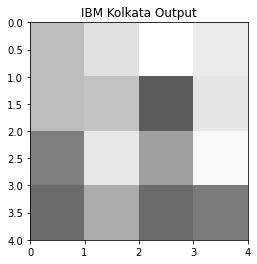

In [30]:
ibm_kolkata_output = [0.25194555, 0.298106, 0.33946189, 0.31093357, 0.25194555, 0.259582, 0.12103073, 0.30458732, 0.16822864, 0.30777681, 0.21194781, 0.33071891, 0.14320549, 0.22750343, 0.14320549, 0.16535946]
np_ibm_kolkata_output = np.array(ibm_kolkata_output).reshape((4,4))
plot_image4x4_brightened(np_ibm_kolkata_output, 'IBM Kolkata Output')

In [33]:
rmse_simulator = rmse_image_error(np_test_image, un_normalize(np_test_image, np_test_image_normalized, np_simulator_output, 4), 4)
rmse_quito = rmse_image_error(np_test_image, un_normalize(np_test_image, np_test_image_normalized, np_ibm_quito_output, 4), 4) 
rmse_kolkata = rmse_image_error(np_test_image, un_normalize(np_test_image, np_test_image_normalized, np_ibm_kolkata_output, 4), 4) 

print("Simulator error: ", (rmse_simulator * 100), "% per pixel")
print("IBM Quito error: ", (rmse_quito * 100), "% per pixel")
print("IBM Kolkata error: ", (rmse_kolkata * 100), "% per pixel")


Simulator error:  0.4719698542319386 % per pixel
IBM Quito error:  3.8318126114852897 % per pixel
IBM Kolkata error:  2.8069918095700905 % per pixel


In [ ]:
# We can now measure RMSE error per pixel. 
# Ideally we want to use SSIM, since it's a better way to compare two images.
# For smaller images, it's just not possible.